This file contains python code to compare with sinica paper

It is under the linear setting

Now, I use the same X and beta from the paper (on Sep 4, 2023)

I analyze the results under new code, here I save the results seperately.

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [23]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT

from hdf_utils.hypo_test import obt_test_stat_simple2, get_Amat, obt_test_stat_simple3
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.misc import save_pkl, load_pkl, get_local_min_idxs
from optimization.one_step_opt import OneStepOpt

from joblib import Parallel, delayed

In [5]:
import logging

logger = logging.getLogger("tmp")
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler() # for console. 
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)

logger.addHandler(ch)

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Fns

In [7]:
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]
_err_fn = lambda x: np.nanmean(x**2)

<function __main__.<lambda>(x)>

# Analysis

In [54]:
#c1s = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
#c1s = [0.05, 0.3, 0.5, 0.6]
#Cmat = np.array([1, -1]).reshape(1, 2)
#c1s = [0.0, 0.2, 0.4]

c1s = [0.0, 0.2, 0.4]
can_Ns = [4, 6, 8]
#can_lams = [0.01, 0.1,  0.3,  0.6, 1, 2, 8];
can_lams = [0.01, 0.1, 0.15, 0.20, 0.25, 0.5, 1.0, 2.0, 8.0]
can_lams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1, 2, 8];
can_lams = [0.001, 0.3, 0.6, 0.8, 1, 1.2, 1.4, 2, 16];
can_lams = [0.001, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50, 2]
can_lams = [0.001, 0.05, 0.10, 0.15, 0.30, 0.50, 2]
can_lams = [0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1, 2, 8];
setting = "setting4a"
can_lams = [0.001, 0.1, 0.3, 0.45, 0.50, 0.55, 0.6, 0.7, 1.0, 2.0, 4.0, 16.0]

Cmat = np.array([1, 0, 0]).reshape(1, 3) # change it depending on test1, test2, test3
Cmat = np.eye(1) # change it depending on test1, test2, test3

num_rep = 50;

## Step 0 (extract cv errrs)

Save in one dict

In [10]:
c1 = 0.0
cur_num_rep = 50
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    
    def _run_fn(seed, N, lam, c1):
        f_fil = list(cur_save_dir.glob(f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}-c1_{c1*1000:.0f}_est.pkl"))[0]
        t_res = load_pkl(f_fil, verbose=0)
        return (seed, N, lam), t_res.cv_errs
    all_coms = itertools.product(range(cur_num_rep), can_Ns, can_lams)
    with Parallel(n_jobs=1) as parallel:
        all_cv_errs_list = parallel(delayed(_run_fn)(cur_seed, cur_N, cur_lam, c1=c1)  
                                 for cur_seed, cur_N, cur_lam
                                 in tqdm(all_coms, total=cur_num_rep*len(can_Ns)*len(can_lams), 
                                                      desc=f"c1: {c1}"))
    all_cv_errs = {res[0]:res[1] for res in all_cv_errs_list};
    save_pkl(cur_save_dir/f"all-cv-errs_c1_{c1*1000:.0f}.pkl", all_cv_errs)

c1: 0.0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:55<00:00, 32.44it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_0/all-cv-errs_c1_0.pkl


c1: 0.2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:52<00:00, 34.14it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_200/all-cv-errs_c1_200.pkl


c1: 0.4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:55<00:00, 32.71it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_400/all-cv-errs_c1_400.pkl


## Step 1 (only need once)

In [11]:
def _run_fn(seed, all_cv_errs):
    errs_N = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            errs.append(_err_fn(all_cv_errs[(seed, cur_N, cur_lam)]))
        min_idx = _get_min_idx(errs);
        errs_N.append((seed, cur_N, can_lams[min_idx], errs[min_idx]))
    errs_N_sorted = sorted(errs_N, key=lambda x:x[-1]);
    return errs_N_sorted[0]

In [16]:
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    all_cv_errs = load_pkl(cur_save_dir/f"all-cv-errs_c1_{c1*1000:.0f}.pkl")
    num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
    # do not make n_jobs>1, it is very slow
    with Parallel(n_jobs=1) as parallel:
        opt_lamNs = parallel(delayed(_run_fn)(cur_seed, all_cv_errs)  
                             for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
    save_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}.pkl", opt_lamNs,is_force=1)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_0/all-cv-errs_c1_0.pkl


c1: 0.0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1090.80it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_0/opt_lamNs_c1_0.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_200/all-cv-errs_c1_200.pkl


c1: 0.2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 942.75it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_200/opt_lamNs_c1_200.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_400/all-cv-errs_c1_400.pkl


c1: 0.4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1094.07it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_400/opt_lamNs_c1_400.pkl


In [17]:
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    opt_lamNs =  load_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}.pkl");
    vs, cts = np.unique(np.array(opt_lamNs)[:, 1:3], axis=0, return_counts=1);
    optN, optlam = vs[np.argmax(cts)]
    print(optN, optlam)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_0/opt_lamNs_c1_0.pkl
6.0 0.45
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_200/opt_lamNs_c1_200.pkl
6.0 0.45
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_400/opt_lamNs_c1_400.pkl
6.0 0.45


In [55]:
def _run_fn1(seed, all_cv_errs):
    errs_mat = []
    for cur_N in can_Ns:
        errs = []
        for cur_lam in can_lams:
            errs.append(_err_fn(all_cv_errs[(seed, cur_N, cur_lam)]))
        errs_mat.append(errs)
    errs_mat = np.array(errs_mat)
    return errs_mat
c1 = 0
cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
all_cv_errs = load_pkl(cur_save_dir/f"all-cv-errs_c1_{c1*1000:.0f}.pkl")
num_seed = len(np.unique(list(map(lambda x: x[0], all_cv_errs.keys()))))
# do not make n_jobs>1, it is very slow
with Parallel(n_jobs=1) as parallel:
    err_ten = parallel(delayed(_run_fn1)(cur_seed, all_cv_errs)  
                             for cur_seed in tqdm(range(num_seed), total=num_seed, desc=f"c1: {c1}"))
err_ten = np.array(err_ten)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_0/all-cv-errs_c1_0.pkl


c1: 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 964.03it/s]


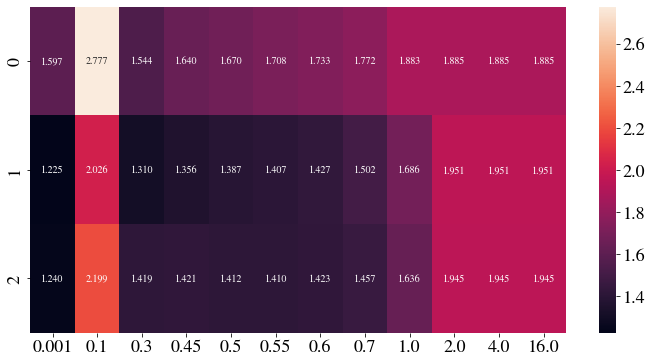

In [57]:
err_m = np.median(np.array(err_ten), axis=0)
plt.figure(figsize=[12, 6])
sns.heatmap(err_m, annot=err_m, fmt=".3f")
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);

## Step 2 (only need once)

In [9]:
def _test_fn(Cmat, est_res, svdinv_eps_Q=0, svdinv_eps_Psi=0, verbose=False):
    torch.set_default_tensor_type(torch.DoubleTensor)
    _paras = est_res._paras
    _paras.svdinv_eps_Q = svdinv_eps_Q
    _paras.svdinv_eps_Psi = svdinv_eps_Psi
    #f_name = f"seed_{_paras.seed:.0f}-lam_{_paras.lam*1000:.0f}-N_{_paras.N:.0f}_test_stat.pkl"
    
    T_v = obt_test_stat_simple2(Q_mat_part=est_res.Q_mat_part,
                               Sig_mat_part=est_res.Sig_mat_part,
                               est_alp=est_res.est_alp, 
                               est_Gam=est_res.est_Gam,
                               Cmat=Cmat,
                               paras=_paras,
                               ).item() 
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    
    res = edict()
    res.T_v = T_v
    res.pval = pval
    res.Cmat = Cmat
    return res

In [21]:
def _test_fn1(Cmat, est_res, svdinv_eps_Q=0, svdinv_eps_Psi=0, 
             is_save=False, verbose=False):
    torch.set_default_tensor_type(torch.DoubleTensor)
    _paras = est_res._paras
    _paras.svdinv_eps_Q = svdinv_eps_Q
    _paras.svdinv_eps_Psi = svdinv_eps_Psi
    
    T_v = obt_test_stat_simple3(est_sigma2=est_res.est_sigma2,
                               Q_mat_part=est_res.Q_mat_part, 
                               est_alp=est_res.est_alp, 
                               est_Gam=est_res.est_Gam,
                               Cmat=Cmat,
                               paras=_paras,
                               ).item() 
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    
    res = edict()
    res.T_v = T_v
    res.pval = pval
    res.Cmat = Cmat
    return res

In [10]:
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    opt_lamNs =  load_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}.pkl");
    vs, cts = np.unique(np.array(opt_lamNs)[:, 1:3], axis=0, return_counts=1);
    optN, optlam = vs[np.argmax(cts)]
    print(optN, optlam)
    ress = []
    for cur_seed in tqdm(range(num_rep), desc=f"c1: {c1*1000:.0f}"):
        cur_N, cur_lam = optN, optlam
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_est.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res = []
        with Parallel(n_jobs=20) as parallel:
            res = parallel(delayed(_test_fn)(Cmat=Cmat, est_res=res1, 
                                             svdinv_eps_Q=rtols[0], 
                                             svdinv_eps_Psi=rtols[1]) for rtols
                                             in all_coms)
    
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNsfixNlam_c1_{c1*1000:.0f}_ress.pkl", ress, is_force=1)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_0/opt_lamNs_c1_0.pkl
6.0 0.3


c1: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  8.00it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_0/opt_lamNsfixNlam_c1_0_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_200/opt_lamNs_c1_200.pkl
6.0 0.3


c1: 200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.66it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_200/opt_lamNsfixNlam_c1_200_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_400/opt_lamNs_c1_400.pkl
6.0 0.3


c1: 400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.84it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_400/opt_lamNsfixNlam_c1_400_ress.pkl


In [27]:
# Given my lam and N
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    opt_lamNs =  load_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}.pkl");
    ress = []
    for cur_seed, cur_N, cur_lam, _ in tqdm(opt_lamNs, desc=f"c1: {c1*1000:.0f}"):
        cur_N, cur_lam = 6, 0.55
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_est.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res = []
        with Parallel(n_jobs=20) as parallel:
            res = parallel(delayed(_test_fn1)(Cmat=Cmat, est_res=res1, 
                                             svdinv_eps_Q=rtols[0], 
                                             svdinv_eps_Psi=rtols[1]) for rtols
                                             in all_coms)
    
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNs1_c1_{c1*1000:.0f}_ress.pkl", ress, is_force=1)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_0/opt_lamNs_c1_0.pkl


c1: 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.28it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_0/opt_lamNs1_c1_0_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_200/opt_lamNs_c1_200.pkl


c1: 200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.42it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_200/opt_lamNs1_c1_200_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_400/opt_lamNs_c1_400.pkl


c1: 400: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.34it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_400/opt_lamNs1_c1_400_ress.pkl


In [30]:
# for adaptive lam N
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = [(can, can) for can in cans]
#all_coms = list(itertools.product(cans, cans))
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    opt_lamNs =  load_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}.pkl");
    ress = []
    for cur_seed, cur_N, cur_lam, _ in tqdm(opt_lamNs, desc=f"c1: {c1*1000:.0f}"):
        f1_name = f"seed_{cur_seed:.0f}-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_{c1*1000:.0f}_est.pkl"
        res1 = load_pkl(cur_save_dir/f1_name, verbose=False);
        res = []
        with Parallel(n_jobs=20) as parallel:
            res = parallel(delayed(_test_fn)(Cmat=Cmat, est_res=res1, 
                                             svdinv_eps_Q=rtols[0], 
                                             svdinv_eps_Psi=rtols[1]) for rtols
                                             in all_coms)
    
        ress.append(res)
    ress = np.array(ress);
    save_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}_ress.pkl", ress, is_force=1)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4i_0/opt_lamNs_c1_0.pkl


c1: 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.70it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4i_0/opt_lamNs_c1_0_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4i_200/opt_lamNs_c1_200.pkl


c1: 200: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 14.50it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4i_200/opt_lamNs_c1_200_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4i_400/opt_lamNs_c1_400.pkl


c1: 400: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.50it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4i_400/opt_lamNs_c1_400_ress.pkl


## Find Q and Psi rtol

In [31]:
ress_dict = {}
for c1 in c1s:
    cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
    ress = load_pkl(cur_save_dir/f"opt_lamNs1_c1_{c1*1000:.0f}_ress.pkl");
    ress_dict[c1] = ress

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_0/opt_lamNs1_c1_0_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_200/opt_lamNs1_c1_200_ress.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting4a_400/opt_lamNs1_c1_400_ress.pkl


In [29]:
import pandas as pd
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
all_coms = np.array(list(itertools.product(cans, cans)));
all_coms = [(can, can) for can in cans]
kpidxs = []

df = []
for c1 in c1s:
    ress = ress_dict[c1]
    pvals = np.array([[re["pval"] for re in res] for res in ress]);
    vec_pv = np.mean(pvals<0.05, axis=0)
    df.append(vec_pv[:, np.newaxis])
df.append(all_coms) 
df = np.hstack(df)
df = pd.DataFrame(df) 
df.columns = c1s+["Q", "Psi"]
df

,0.0,0.2,0.4,Q,Psi
0,0.0,0.14,0.5,1.000000e-05,1.000000e-05
1,0.0,0.14,0.5,3.000000e-06,3.000000e-06
2,0.0,0.14,0.5,1.000000e-06,1.000000e-06
3,0.0,0.14,0.5,3.000000e-07,3.000000e-07
4,0.0,0.14,0.5,1.000000e-07,1.000000e-07
5,0.0,0.14,0.5,3.000000e-08,3.000000e-08
6,0.0,0.14,0.5,1.000000e-08,1.000000e-08
7,0.0,0.14,0.5,3.000000e-09,3.000000e-09
8,0.0,0.14,0.5,1.000000e-09,1.000000e-09
9,0.0,0.14,0.5,3.000000e-10,3.000000e-10


In [ ]:
df_sel = df[(df[0.0]<=0.053) & (df[0.2]>=0.37)]

In [ ]:
df

In [26]:
vec.shape

(121,)

## Opt N and lams

In [106]:
c1 = 0.2
opt = load_pkl(paras.save_dir/f"opt_lamNs_200_c1_{c1*1000:.0f}.pkl");
opt_ress = load_pkl(paras.save_dir/f"opt_lamNs_200_c1_{c1*1000:.0f}_ress.pkl");
all_coms = np.array(list(itertools.product(cans, cans)));

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_samebetaX_test1/opt_lamNs_200_c1_200.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_samebetaX_test1/opt_lamNs_200_c1_200_ress.pkl


In [107]:
opt = np.array(opt)
np.unique(np.array(opt)[:, 1:3], axis=0, return_counts=1)

(array([[ 4. ,  0.1],
        [ 4. ,  0.2],
        [ 4. ,  0.3],
        [ 4. ,  0.4],
        [ 6. ,  0.1],
        [ 6. ,  0.2],
        [ 6. ,  0.3],
        [ 8. ,  0.2],
        [ 8. ,  0.3],
        [ 8. ,  0.4],
        [10. ,  0.1],
        [10. ,  0.3],
        [12. ,  0.2],
        [12. ,  0.3],
        [12. ,  0.4]]),
 array([ 3, 51, 60,  1,  4, 18, 25, 10, 14,  2,  1,  1,  3,  4,  3]))

In [108]:
kpidx = np.bitwise_and(all_coms[:, 0]==1e-7, all_coms[:, 1]==1e-8);
Tvs = opt_ress[:, kpidx, 0].reshape(-1)
pvals = opt_ress[:, kpidx, 1].reshape(-1);

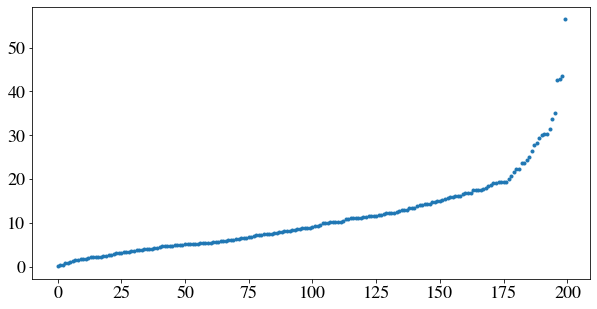

In [109]:
plt.figure(figsize=[10, 5])
plt.plot(np.sort(Tvs), ".")

In [ ]:
opt[pvals<0.05], Tvs[pvals<0.05]

In [111]:
mat1 = np.zeros((len(can_Ns), len(can_lams)))
mat2 = np.zeros((len(can_Ns), len(can_lams)))
for lamN, pval in zip(opt, pvals):
    if pval >= 0.05:
        mat1[can_Ns.index(lamN[1]), can_lams.index(lamN[2])] += 1
    else:
        mat2[can_Ns.index(lamN[1]), can_lams.index(lamN[2])] += 1

Text(970.2, 0.5, 'N')

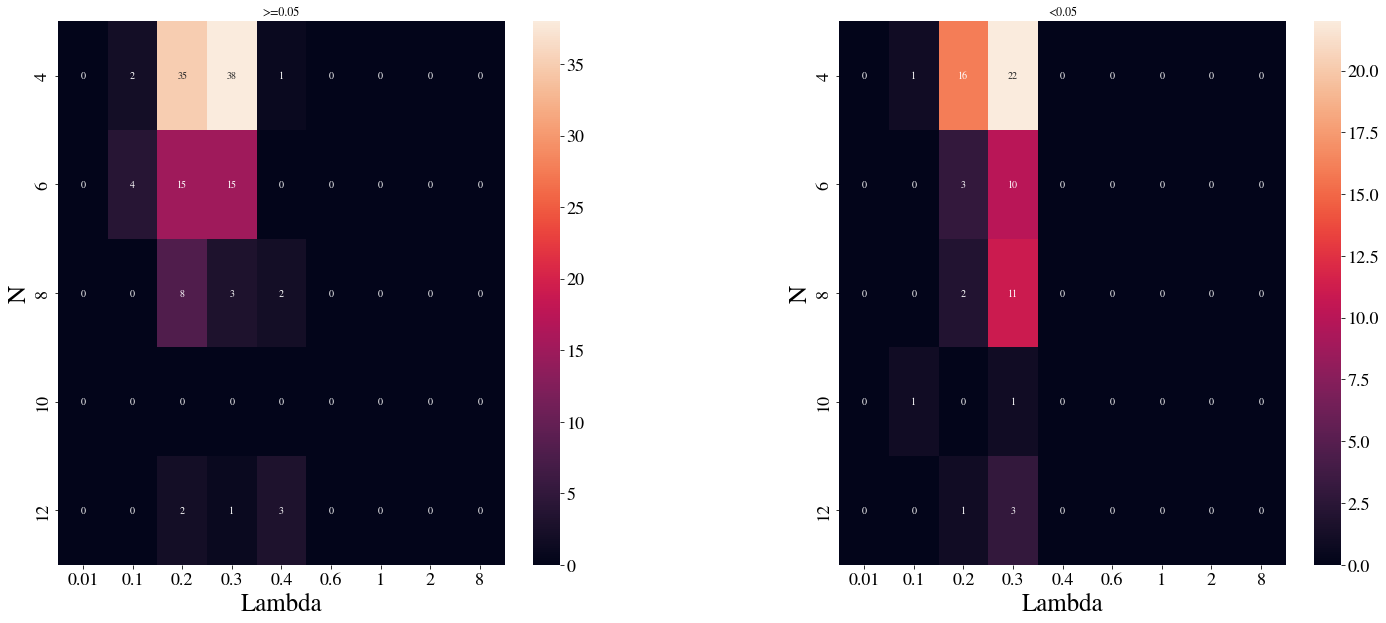

In [112]:
plt.figure(figsize=[24, 10])
plt.subplot(121)
plt.title(">=0.05")
sns.heatmap(mat1, annot=True)
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.xlabel("Lambda")
plt.ylabel("N")

plt.subplot(122)
plt.title("<0.05")
sns.heatmap(mat2, annot=True)
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns);
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.xlabel("Lambda")
plt.ylabel("N")

# Sinica results

In [23]:
setting = "setting4a"
sini_paras = edict()
sini_paras.dir = RES_ROOT/f"sinica_results/SinicaX_d-200_n-100_{setting}";
c1s = [0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6];
c1s = [0.0, 0.2, 0.4]

[0.0, 0.2, 0.4]

In [28]:
c1 = 0
all_fils = list(sini_paras.dir.glob(f"c1_{c1*1000:.0f}_*.mat"));
sorted_all_fils = sorted(all_fils, key=lambda x: int(x.stem.split("_")[3]));
    
sini_pvals = []
opt_sns = []
for fil in sorted_all_fils:
        res = loadmat(fil);
        sini_pvals.append(res["pval"][0][0])
        opt_sns.append(res["gopt_sn"][0][0])
sini_pvals0 = np.array(sini_pvals);
opt_sns0 = np.array(opt_sns);

In [29]:
c1 = 0.2
all_fils = list(sini_paras.dir.glob(f"c1_{c1*1000:.0f}_*.mat"));
sorted_all_fils = sorted(all_fils, key=lambda x: int(x.stem.split("_")[3]));
    
sini_pvals = []
opt_sns = []
for fil in sorted_all_fils:
        res = loadmat(fil);
        sini_pvals.append(res["pval"][0][0])
        opt_sns.append(res["gopt_sn"][0][0])
sini_pvals1 = np.array(sini_pvals);
opt_sns1 = np.array(opt_sns);

In [24]:
pvals_sinica = []
for c1 in c1s:
    all_fils = list(sini_paras.dir.glob(f"c1_{c1*1000:.0f}_*.mat"));
    sorted_all_fils = sorted(all_fils, key=lambda x: int(x.stem.split("_")[3]));
    
    sini_pvals = []
    opt_sns = []
    for fil in sorted_all_fils:
        res = loadmat(fil);
        sini_pvals.append(res["pval"][0][0])
        opt_sns.append(res["gopt_sn"][0][0])
    sini_pvals = np.array(sini_pvals);
    opt_sns = np.array(opt_sns);
    #save_pkl(sini_paras.dir/f"c1_{c1*1000:.0f}_pvals.pkl", sini_pvals, is_force=False)
    pvals_sinica.append(np.mean(sini_pvals < 0.05))
    print(f"The power under c1={c1:.3f} {len(sini_pvals)} is {np.mean(sini_pvals < 0.05):.3f}.")

The power under c1=0.000 200 is 0.045.
The power under c1=0.200 200 is 0.045.
The power under c1=0.400 200 is 0.045.


In [49]:
res["gopt_lam_d"]

array([[0.026285]])

array([[0.17300987]])

In [25]:
pvals_sinica = []
for c1 in c1s:
    sini_pvals = load_pkl(sini_paras.dir/f"c1_{c1*1000:.0f}_pvals.pkl")
    pvals_sinica.append(np.mean(sini_pvals < 0.05))

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/sinica_results/SinicaX_d-200_n-100_test1_setting1/c1_0_pvals.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/sinica_results/SinicaX_d-200_n-100_test1_setting1/c1_50_pvals.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/sinica_results/SinicaX_d-200_n-100_test1_setting1/c1_100_pvals.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/sinica_results/SinicaX_d-200_n-100_test1_setting1/c1_200_pvals.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/sinica_results/SinicaX_d-200_n-100_test1_setting1/c1_300_pvals.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/sinica_results/Sinic

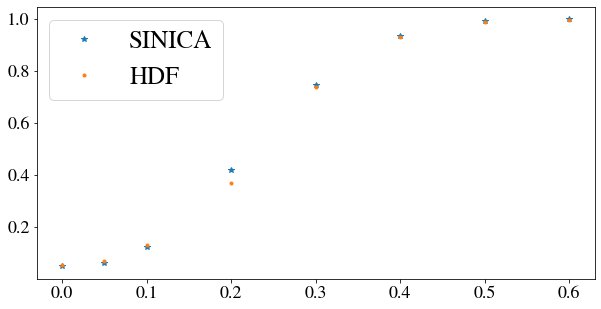

In [26]:
pvals_hdf = np.array(df_sel.iloc[1][:-2]);
plt.figure(figsize=[10, 5])
plt.plot(c1s, pvals_sinica, "*", label="SINICA")
plt.plot(c1s, pvals_hdf, ".", label="HDF")
plt.legend()

In [27]:
np.round(np.array([pvals_hdf, pvals_sinica]), 3)

array([[0.053, 0.068, 0.132, 0.371, 0.737, 0.932, 0.99 , 0.998],
       [0.048, 0.06 , 0.123, 0.421, 0.746, 0.935, 0.992, 0.999]])

# Check

In [112]:
def _test_fn(Cmat, est_res, svdinv_eps_Q=0, svdinv_eps_Psi=0, verbose=False):
    torch.set_default_tensor_type(torch.DoubleTensor)
    _paras = est_res._paras
    _paras.svdinv_eps_Q = svdinv_eps_Q
    _paras.svdinv_eps_Psi = svdinv_eps_Psi
    #f_name = f"seed_{_paras.seed:.0f}-lam_{_paras.lam*1000:.0f}-N_{_paras.N:.0f}_test_stat.pkl"
    
    T_v = obt_test_stat_simple2(Q_mat_part=est_res.Q_mat_part, 
                               Sig_mat_part=est_res.Sig_mat_part,
                               est_alp=est_res.est_alp, 
                               est_Gam=est_res.est_Gam,
                               Cmat=Cmat,
                               paras=_paras,
                               ).item() 
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    
    res = edict()
    res.T_v = T_v
    res.pval = pval
    res.Cmat = Cmat
    return res

'setting1'

In [69]:
cans = [1e-5, 3e-6, 1e-6, 3e-7, 1e-7, 3e-8, 1e-8, 3e-9, 1e-9, 3e-10, 0]
setting = "setting1i"
all_coms = np.array(list(itertools.product(cans, cans)));
c1 = 0.2
cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
res1 = load_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}.pkl");
res1 = np.array(res1)
res2 = load_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}_ress.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_200/opt_lamNs_c1_200.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_200/opt_lamNs_c1_200_ress.pkl


In [70]:
pd.DataFrame(res1)

,0,1,2,3
0,0.0,12.0,0.001,0.809441
1,1.0,6.0,0.300,1.223911
2,2.0,8.0,0.600,0.957348
3,3.0,6.0,0.300,1.116402
4,4.0,6.0,0.600,1.201132
...,...,...,...,...
195,195.0,6.0,0.300,1.062005
196,196.0,6.0,0.300,1.142312
197,197.0,10.0,0.800,1.186515
198,198.0,6.0,0.300,1.002838


In [42]:
tmp_res = load_pkl(cur_save_dir/"seed_199-lam_1000-N_6-c1_200_est.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_200/seed_199-lam_1000-N_6-c1_200_est.pkl


In [43]:
np.mean((tmp_res.cv_errs)**2)

1.7311553046967603

In [44]:
torch.linalg.norm(tmp_res.est_Gam, dim=0)

tensor([10.1190,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.8305])

In [104]:
c1 = 0 
cur_save_dir = RES_ROOT/f"simu_{setting}_{c1*1000:.0f}"
optlamNs = load_pkl(cur_save_dir/f"opt_lamNs_c1_{c1*1000:.0f}.pkl");
all_cv_errs = load_pkl(cur_save_dir/f"all-cv-errs_c1_{c1*1000:.0f}.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_0/opt_lamNs_c1_0.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../results/simu_setting1i_0/all-cv-errs_c1_0.pkl


In [129]:
np.unique(np.array(optlamNs)[:, 1:3], axis=0, return_counts=1)

(array([[4.0e+00, 3.0e-01],
        [6.0e+00, 1.0e-03],
        [6.0e+00, 3.0e-01],
        [6.0e+00, 6.0e-01],
        [8.0e+00, 3.0e-01],
        [8.0e+00, 6.0e-01],
        [8.0e+00, 8.0e-01],
        [1.0e+01, 1.0e-03],
        [1.0e+01, 3.0e-01],
        [1.0e+01, 6.0e-01],
        [1.0e+01, 8.0e-01],
        [1.2e+01, 1.0e-03],
        [1.2e+01, 3.0e-01],
        [1.2e+01, 6.0e-01],
        [1.2e+01, 8.0e-01]]),
 array([14,  1, 98, 27, 11, 11,  1,  1,  8,  5,  2, 10,  9,  1,  1]))

In [119]:

seed = 0
lamNs = list(itertools.product([seed], can_Ns, can_lams))
errs = []
for key in lamNs:
    errs.append(np.mean((all_cv_errs[key])**2))
errs = np.array(errs)
_, optN, optlam, _ = optlamNs[seed]
optlamNs[seed]

(0, 12, 0.001, 0.7811521027624267)

In [124]:
f_fil = list(cur_save_dir.glob(f"seed_{seed:.0f}-lam_{optlam*1000:.0f}-N_{optN:.0f}-c1_{c1*1000:.0f}_est.pkl"))[0]
t_res = load_pkl(f_fil, verbose=0);
torch.linalg.norm(t_res.est_Gam, dim=0)

tensor([0.2214, 0.4468, 0.2343, 0.2204, 0.1974, 0.2667, 0.1496, 0.3123, 0.3195,
        0.3026, 0.3238, 0.1254, 0.2767, 0.1914, 0.2042, 0.1299, 0.1522, 0.2194,
        0.3077, 0.2846, 0.2165, 0.3433, 0.2467, 0.3257, 0.2703, 0.3141, 0.3256,
        0.2452, 0.1793, 0.1581, 0.1918, 0.2839, 0.3419, 0.2224, 0.2938, 0.2582,
        0.2572, 0.3183, 0.2445, 0.3869, 0.6264])

In [125]:
t_res._paras.keep_idxs

array([  0,   4,   6,   7,  12,  13,  36,  54,  56,  59,  62,  68,  69,
        71,  76,  77,  78,  81,  82,  95, 103, 116, 121, 122, 127, 128,
       132, 133, 134, 135, 136, 141, 147, 148, 150, 157, 166, 173, 181,
       198, 199])

Text(0.5, 23.20659722222222, 'Lam')

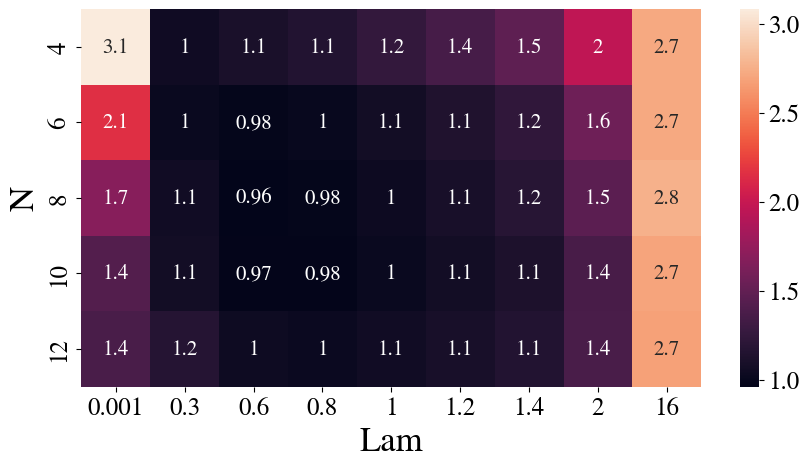

In [117]:
lamNsnp = np.array(lamNs);
lamNsnp[:, 1].reshape(len(can_Ns), -1)
errs_mat = errs.reshape(len(can_Ns), -1)
sns.heatmap(errs_mat, annot=np.round(errs_mat, 2))
plt.yticks(np.arange(len(can_Ns))+0.5, can_Ns)
plt.xticks(np.arange(len(can_lams))+0.5, can_lams);
plt.ylabel("N")
plt.xlabel("Lam")